## 0.01 Bandwidth

In [ ]:
import os
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel
from sklearn.preprocessing import MinMaxScaler
import copy
from quask.evaluator import CenteredKernelAlignmentEvaluator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

data_dir = 'ATTACKDATA'

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
_service = QiskitRuntimeService(name="cotrum")
backend = _service.backend("ibm_rensselaer")
options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=options,
        backend=backend,
    )

# Instantiate a machine learning model
model = SVC(kernel='precomputed')

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
# KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
KernelFactory.set_current_implementation('qiskit_ibm')




# Step 1: List your 16 .npy files (sorted to ensure consistency)
directory = 'ATTACKDATA'
filenames = sorted([f for f in os.listdir(directory) if f.endswith('.npy')])

# Step 2: Your 16 pre-calculated numbers
bandwidths = [0.9, 0.9, 1.8, 1.8, 5.0, 5.0, 3.4, 3.4, 5.2, 5.2, 5.1, 5.1, 3.4, 3.4, 3.3, 3.3, 0.6, 0.6, 1.5, 1.5, 3.3, 3.3, 5.4,5.4, 2.8, 2.8, 2.1, 2.1, 3.6, 3.6, 4.0, 4.0]  # length must be 16

# Step 3: Map filenames to numbers
map = {filename: bandwidth for filename, bandwidth in zip(filenames, bandwidths)}







# ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
# ansatz.initialize_to_identity()
# # e.g. set operations...
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=.1)
# ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=.1)
# ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=.1)
# ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=.1)
# ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=.1)
# ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=.1)
# ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=.1)
# ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=.1)


# kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

for fname, bandwidth in map.items():
    # Only consider benign files (and skip certain ones)
    if fname.endswith('.npy') and 'benign' in fname:

        benign_path = os.path.join(data_dir, fname)

        # Construct the matching attack filename
        attack_fname = fname.replace('benign', 'attack')
        attack_path = os.path.join(data_dir, attack_fname)

        if os.path.exists(attack_path):
            # Load the arrays
            qX1 = np.load(benign_path, allow_pickle=True)
            qX2 = np.load(attack_path, allow_pickle=True)

            # Now you can use `value` associated with this file

            columns = [3, 4, 5, 6, 7, 8, 9, 10]
            qX1 = qX1[:10,columns]
            qX2 = qX2[:10,columns]

            qX = np.row_stack([qX1, qX2])
            qy = np.array([-1] * len(qX1) + [1] * len(qX2))


            qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

            # reduce dimensionality
            # pca = PCA(n_components=2).fit(qX_train)
            # X_train = pca.transform(qX_train)
            # X_test = pca.transform(qX_test)
            
            # normalize data
            samples = np.append(qX_train, qX_test, axis=0)
            minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
            qX_train = minmax_scale.transform(qX_train)
            qX_test = minmax_scale.transform(qX_test)

            attack_label = attack_fname.split("attack")[0]
            
            
            
            # label_mapping = { -1: 'Benign', 1: attack_label.upper() }


            # for k in [-1, 1]:
            #     x_axis_data = qX_train[qy_train == k, 0][:400]
            #     y_axis_data = qX_train[qy_train == k, 1][:400]
            #     plt.scatter(x_axis_data, y_axis_data, label=label_mapping[k], alpha=0.5)

            # plt.title(f"{attack_label.upper()} point visualization (PCA)")
            # plt.xlabel("Component 1")
            # plt.ylabel("Component 2")
            # plt.legend()
            # plt.show()

            # # --- FIGURE 2: Zoomed on Attack region ---
            # # compute the attack bounds + padding
            # atk_mask = (qy_train == 1)
            # x_atk = qX_train[atk_mask, 0][:400]
            # y_atk = qX_train[atk_mask, 1][:400]

            # x_min, x_max = x_atk.min(), x_atk.max()
            # y_min, y_max = y_atk.min(), y_atk.max()
            # x_pad = (x_max - x_min) * 0.1
            # y_pad = (y_max - y_min) * 0.1

            # plt.figure(figsize=(6,5))
            # for k in [-1, 1]:
            #     x = qX_train[qy_train == k, 0][:400]
            #     y = qX_train[qy_train == k, 1][:400]
            #     plt.scatter(x, y, label=label_mapping[k], alpha=0.5)
            # # now zoom:
            # plt.xlim(x_min - x_pad, x_max + x_pad)
            # plt.ylim(y_min - y_pad, y_max + y_pad)

            # plt.title(f"Focused {attack_label.upper()}")
            # plt.xlabel("Component 1")
            # plt.ylabel("Component 2")
            # plt.legend()
            # plt.show()


            # OPTIMIZE KERNEL
            # from quask.optimizer.bayesian_optimizer import BayesianOptimizer
            # ce = CenteredKernelAlignmentEvaluator()
            # optimizer = BayesianOptimizer(kernel, qX_train, qy_train, ce)
            # optimized_kernel = optimizer.optimize()


            # start = 0.0
            # end = math.pi * 2
            # while start <= end:
            ansatz = Ansatz(n_features=8, n_qubits=8, n_operations=8)
            ansatz.initialize_to_identity()
            # e.g. set operations...
            ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=bandwidth)
            ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=bandwidth)
            ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=bandwidth)
            ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=bandwidth)
            ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=bandwidth)
            ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=bandwidth)
            ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=bandwidth)
            ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=bandwidth)


            kernel = KernelFactory.create_kernel(ansatz, "ZZZZZZZZ", KernelType.FIDELITY)
            kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).
            K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data

            model.fit(K_train, qy_train)
        
            # Predict the labels for the test data
            K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
            y_pred = model.predict(K_test)

            # Calculate the accuracy
            accuracy = np.sum(qy_test == y_pred) / len(qy_test)
            print(f"Accuracy for {attack_label} for bandwidth {bandwidth} is {accuracy}")

                # start += 0.2



Number of circuits (isa_circuits):  120
Job sent to hardware. Job ID: d1nirc33rr0s73bfccig
Job sent to hardware. Job ID: d1nit8gt0npc73fkptag
Accuracy for bfftp for bandwidth 0.9 is 0.75
Number of circuits (isa_circuits):  120
Job sent to hardware. Job ID: d1nivf95jdrc73dqkmug
Job sent to hardware. Job ID: d1nj2an6d0hc73b669d0
Accuracy for bfssh for bandwidth 1.8 is 0.75
Number of circuits (isa_circuits):  120
Job sent to hardware. Job ID: d1nj3vn6d0hc73b66b20
Job sent to hardware. Job ID: d1nj69h5jdrc73dqktj0
Accuracy for bfweb for bandwidth 5.0 is 1.0
Number of circuits (isa_circuits):  120
Job sent to hardware. Job ID: d1nj748t0npc73fkq780
Job sent to hardware. Job ID: d1nj8hj3rr0s73bfcpgg
Accuracy for bfxss for bandwidth 3.4 is 0.5
Number of circuits (isa_circuits):  120
Job sent to hardware. Job ID: d1nj9eb3rr0s73bfcqbg
Job sent to hardware. Job ID: d1njarr3rr0s73bfcrlg
Accuracy for botnet for bandwidth 5.2 is 1.0
Number of circuits (isa_circuits):  120
Job sent to hardware. Job I

RequestsApiError: '403 Client Error: Forbidden for url: https://quantum.cloud.ibm.com/api/v1/jobs/d1njm5v6d0hc73b66stg?exclude_params=true. {"errors":[{"code":1200,"message":"You are not authorized to perform this action.","solution":"Try again or contact support.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"9acb6e56-b4db-4542-a348-0a6448d6cb7c"}\n'

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import dask.dataframe as dd

# --- Load ---
df_attack = dd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_loic_http/tuesday_20_02_2018_loic_http.csv',
    
)
df_benign = dd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_benign/tuesday_20_02_2018_benign.csv',
    
)

# # --- Keep numeric columns ---
X_attack = df_attack.select_dtypes(include=[np.number]).copy()
X_benign = df_benign.select_dtypes(include=[np.number]).copy()

# # --- Replace inf with NaN ---
# X_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

# # --- Drop columns with >20% missing in attack ---
# miss_thresh = 0.2
# good_cols = X_attack.isnull().mean() < miss_thresh
# X_attack = X_attack.loc[:, good_cols]
# X_benign = X_benign.loc[:, good_cols]

# # --- Drop single-value columns (attack) ---
# multi_cols = X_attack.nunique()[X_attack.nunique() > 1].index
# shared_cols = [col for col in multi_cols if col in X_benign.columns]
# X_attack = X_attack[shared_cols]
# X_benign = X_benign[shared_cols]

# # --- Drop highly collinear columns (corr > 0.95) ---
# corr = X_attack.corr().abs()
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
# X_attack = X_attack.drop(columns=to_drop)
# X_benign = X_benign.drop(columns=to_drop)

# # --- Drop any column from benign that still has NaNs ---
# no_nan_cols = X_benign.columns[~X_benign.isnull().any()]
# X_attack = X_attack[no_nan_cols]
# X_benign = X_benign[no_nan_cols]


qX1 = X_benign
qX2 = X_attack

qX1 = qX1.loc[~(qX1 == 0.0).all(axis=1)]
qX2 = qX2.loc[~(qX2 == 0.0).all(axis=1)]
# 1. Combine and label
X = pd.concat([qX1, qX2], axis=0)
y = np.array([0] * len(qX1) + [1] * len(qX2))  # 0 = benign, 1 = attack

from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

# 4. Re-slice your datasets to only those top features
# qX1 = qX1[top_features].copy()
# qX2 = qX2[top_features].copy()

# print("\nAfter selecting top features:")
# print("Benign shape:", qX1_top.shape)
# print("Attack shape:", qX2_top.shape)
# --- Normalize to [-1, 1] ---
# scaler = MinMaxScaler(feature_range=(-1, 1))
# combined_scaled = pd.concat([qX1, qX2])
# scaler.fit(combined_scaled)

# qX1 = pd.DataFrame(scaler.transform(qX1), columns=top_features)
# qX2 = pd.DataFrame(scaler.transform(qX2), columns=top_features)

# --- Final Output ---
# print("Final selected features:", qX2.columns)
# print("Benign shape:", qX1.shape)
# print("Attack shape:", qX2.shape)


TypeError: cannot concatenate object of type '<class 'dask.dataframe.dask_expr._collection.DataFrame'>'; only Series and DataFrame objs are valid

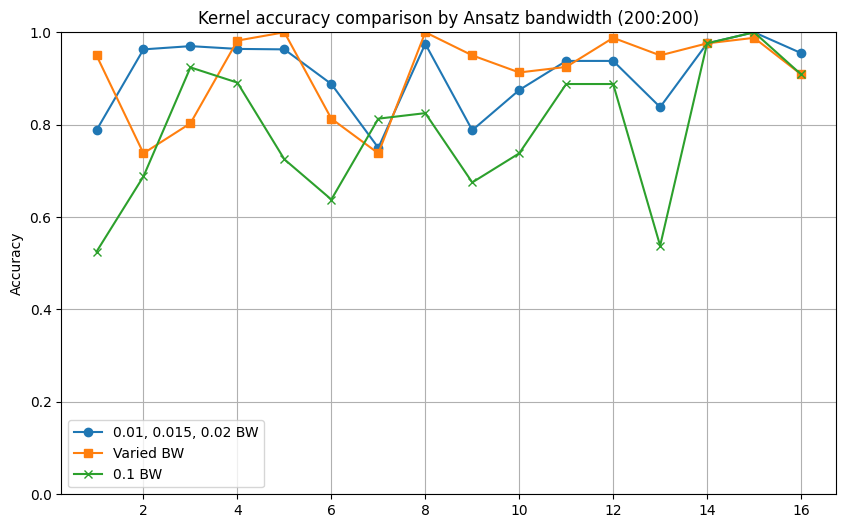

In [ ]:
import matplotlib.pyplot as plt

# Sample data: two lists with 16 corresponding data points
set_bw = [0.788, 0.963, 0.970, 0.964, 0.963, 0.888, 0.750, 0.975, 0.788, 0.875, 0.938, 0.938, 0.838, 0.976, 1.00, 0.955]
var_bw = [0.950, 0.738, 0.803, 0.982, 1.00, 0.813, 0.738, 1.00, 0.950, 0.913, 0.925, 0.988, 0.950, 0.976, 0.988, 0.909]

# add other lists for comparison
orig_bw = [0.525, 0.688, 0.924, 0.891, 0.725, 0.638, 0.813, 0.825, 0.675, 0.738, 0.888, 0.888, 0.538, 0.976, 1.00, 0.909]


# X-axis values (assuming index as x-axis)
x_values = list(range(1, 17))

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, set_bw, marker='o', label='0.01, 0.015, 0.02 BW')
plt.plot(x_values, var_bw, marker='s', label='Varied BW')
plt.plot(x_values, orig_bw, marker='x', label='0.1 BW')
plt.title('Kernel accuracy comparison by Ansatz bandwidth (200:200)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


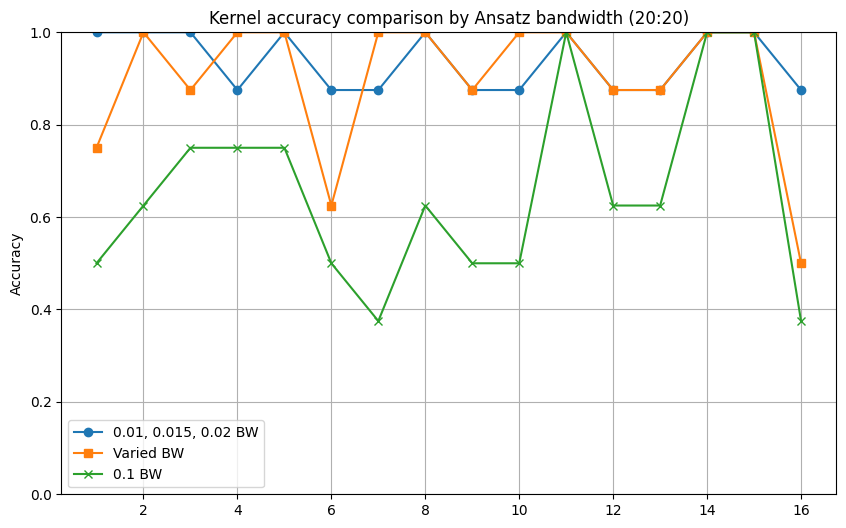

In [21]:
import matplotlib.pyplot as plt

# Sample data: two lists with 16 corresponding data points
set_bw = [1, 1, 1, .875, 1, 0.875, 0.875, 1, 0.875, 0.875, 1, 0.875, 0.875, 1, 1, 0.875]
var_bw = [0.75, 1, .875, 1, 1, .625, 1, 1, .875, 1, 1, .875, .875, 1, 1, .5]

# add other lists for comparison
orig_bw = [0.5, 0.625, 0.75, .75, .75, .5, .375, .625, .5, .5, 1, .625, .625, 1, 1, .375]


# X-axis values (assuming index as x-axis)
x_values = list(range(1, 17))

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, set_bw, marker='o', label='0.01, 0.015, 0.02 BW')
plt.plot(x_values, var_bw, marker='s', label='Varied BW')
plt.plot(x_values, orig_bw, marker='x', label='0.1 BW')
plt.title('Kernel accuracy comparison by Ansatz bandwidth (20:20)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


## compare NISQ w Aer

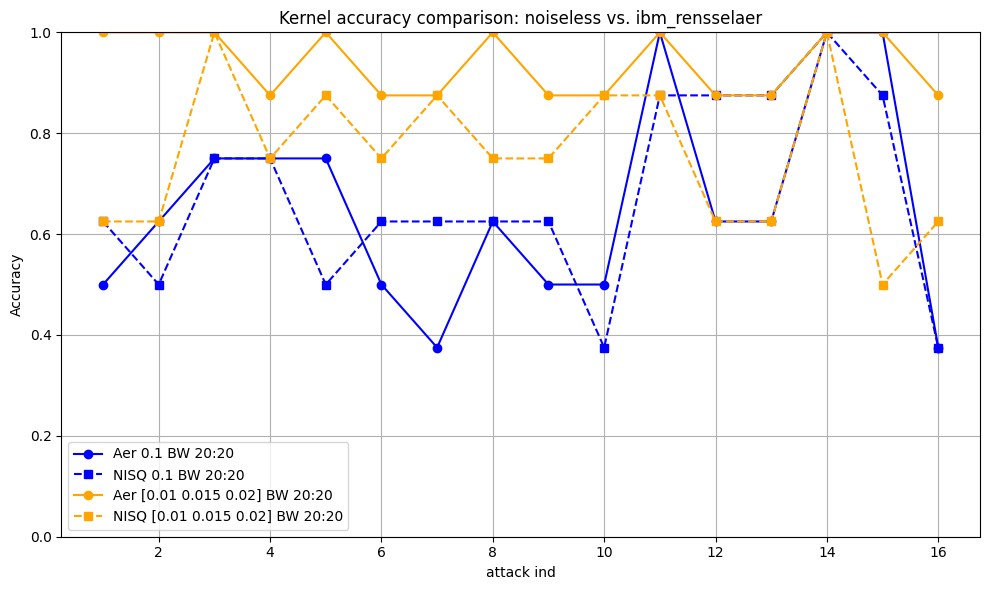

In [26]:
import matplotlib.pyplot as plt

# Aer 20:20, 0.1
aer1 = [0.5, 0.625, 0.75, 0.75, 0.75, 0.5, 0.375, 0.625, 0.5, 0.5, 1, 0.625, 0.625, 1, 1, 0.375]
# NISQ 20:20, 0.1
nisq1 = [0.625, .5, 0.75, 0.75, 0.5, 0.625, 0.625, 0.625, 0.625, 0.375, 0.875, 0.875, 0.875, 1, 0.875, 0.375]
# Aer 0.01, 0.015, 0.02
aer2 = [1, 1, 1, .875, 1, 0.875, 0.875, 1, 0.875, 0.875, 1, 0.875, 0.875, 1, 1, 0.875]
# NISQ 0.01, 0.015, 0.02
nisq2 = [0.625, 0.625, 1, .75, .875, .75, .875, .75, .75, .875, .875, .625, .625, 1, .5, .625]

# X-axis values
x_values = list(range(1, 17))

# Create the line graph
plt.figure(figsize=(10, 6))

# Group 1: Aer1 and NISQ1 (same color)
plt.plot(x_values, aer1, marker='o', linestyle='-', color='blue', label='Aer 0.1 BW 20:20')
plt.plot(x_values, nisq1, marker='s', linestyle='--', color='blue', label='NISQ 0.1 BW 20:20')

# Group 2: Aer2 and NISQ2 (same color)
plt.plot(x_values, aer2, marker='o', linestyle='-', color='orange', label='Aer [0.01 0.015 0.02] BW 20:20')
plt.plot(x_values, nisq2, marker='s', linestyle='--', color='orange', label='NISQ [0.01 0.015 0.02] BW 20:20')

# Formatting
plt.title('Kernel accuracy comparison: noiseless vs. ibm_rensselaer')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('attack ind')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


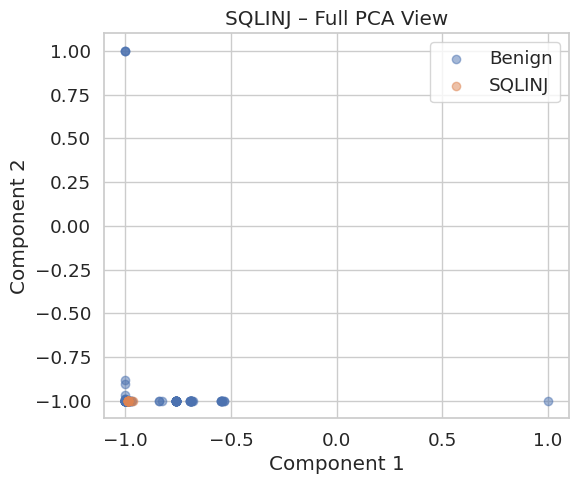

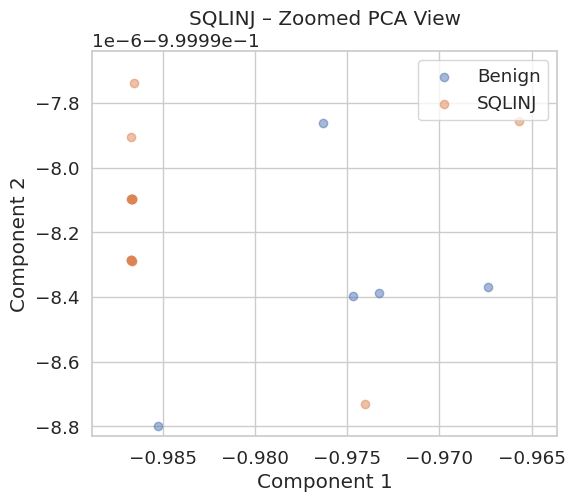

In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1) scale exactly as before
samples = np.append(qX_train, qX_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
qX_train = minmax_scale.transform(qX_train)
qX_test  = minmax_scale.transform(qX_test)

attack_label  = attack_fname.split("attack")[0].upper()
label_mapping = { -1: 'Benign', 1: attack_label }

# --- FIGURE 1: Full PCA scatter ---
plt.figure(figsize=(6,5))
for k in [-1, 1]:
    x = qX_train[qy_train == k, 0][:400]
    y = qX_train[qy_train == k, 1][:400]
    plt.scatter(x, y, label=label_mapping[k], alpha=0.5)
plt.title(f"{attack_label} – Full PCA View")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


# --- FIGURE 2: Zoomed on Attack region ---
# compute the attack bounds + padding
atk_mask = (qy_train == 1)
x_atk = qX_train[atk_mask, 0][:400]
y_atk = qX_train[atk_mask, 1][:400]

x_min, x_max = x_atk.min(), x_atk.max()
y_min, y_max = y_atk.min(), y_atk.max()
x_pad = (x_max - x_min) * 0.1
y_pad = (y_max - y_min) * 0.1

plt.figure(figsize=(6,5))
for k in [-1, 1]:
    x = qX_train[qy_train == k, 0][:400]
    y = qX_train[qy_train == k, 1][:400]
    plt.scatter(x, y, label=label_mapping[k], alpha=0.5)
# now zoom:
plt.xlim(x_min - x_pad, x_max + x_pad)
plt.ylim(y_min - y_pad, y_max + y_pad)

plt.title(f"{attack_label} – Zoomed PCA View")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


In [2]:
service = QiskitRuntimeService(name="cotrum")
service.backends(dynamic_circuits=True)

[<IBMBackend('ibm_rensselaer')>]

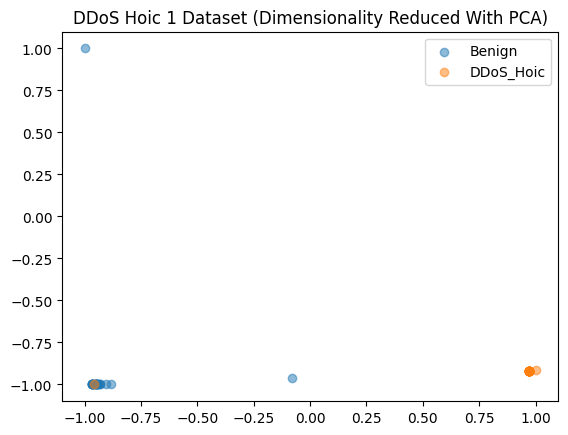

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


class_labels = [r'Benign', r'DDoS_Hoic']
pca = PCA(n_components=2).fit(qX_train)
X_train = pca.transform(qX_train)
X_test = pca.transform(qX_test)

samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

training_input = {key: (X_train[qy_train == k, :])[:320] for k, key in enumerate(class_labels)}
test_input = {key: (X_test[qy_test == k, :])[:80] for k, key in enumerate(class_labels)}


label_mapping = { -1: 'Benign', 1: 'DDoS_Hoic' }


for k in [-1, 1]:
    x_axis_data = X_train[qy_train == k, 0][:320]
    y_axis_data = X_train[qy_train == k, 1][:320]
    plt.scatter(x_axis_data, y_axis_data, label=label_mapping[k], alpha=0.5)

plt.title("DDoS Hoic 1 Dataset (Dimensionality Reduced With PCA)")
plt.legend()
plt.show()

## Bandwidth = 0.015

In [9]:
data_dir = 'ATTACKDATA/0.015/'


ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.015)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.015)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.015)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.015)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.015)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.015)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.015)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.015)


kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

for fname in os.listdir(data_dir):
    # only consider benign files
    if fname.endswith('.npy') and 'benign' in fname:
        benign_path = os.path.join(data_dir, fname)
        # construct the matching attack filename
        attack_fname = fname.replace('benign', 'attack')
        attack_path = os.path.join(data_dir, attack_fname)

        if os.path.exists(attack_path):
            # load arrays
            qX1 = np.load(benign_path, allow_pickle=True)
            qX2 = np.load(attack_path, allow_pickle=True)

            columns = [3, 4, 5, 6, 7, 8, 9, 10]
            qX1 = qX1[:20,columns]
            qX2 = qX2[:20,columns]

            qX = np.row_stack([qX1, qX2])
            qy = np.array([-1] * len(qX1) + [1] * len(qX2))


            qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

            K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data

            model.fit(K_train, qy_train)
        
            # Predict the labels for the test data
            K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
            y_pred = model.predict(K_test)

            # Calculate the accuracy
            accuracy = np.sum(qy_test == y_pred) / len(qy_test)
            print(f"Accuracy for {fname} is {accuracy}")

            

Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1ma3tva572c7398ah1g
Job sent to hardware. Job ID: d1ma5n4uvp6s73cb3l80
Job sent to hardware. Job ID: d1ma7cb9fb3c73eikdeg
Job sent to hardware. Job ID: d1ma91n29o4s73aqnb6g
Job sent to hardware. Job ID: d1ma9o7a572c7398anj0
Job sent to hardware. Job ID: d1mablcuvp6s73cb3s60
Accuracy for bfsshbenign_200.npy is 0.625
Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1mad539fb3c73eikkng
Job sent to hardware. Job ID: d1maern29o4s73aqnj70
Job sent to hardware. Job ID: d1maghna572c7398b06g
Job sent to hardware. Job ID: d1mai84uvp6s73cb44e0
Job sent to hardware. Job ID: d1maiu729o4s73aqnou0
Job sent to hardware. Job ID: d1malpn29o4s73aqnsh0
Accuracy for doshulk2benign_200.npy is 0.75
Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1man739fb3c73eil1f0
Job sent to hardware. Job ID: d1maosf29o4s73aqo040
Job sent to hardware. Job ID: d1maqh4uvp6s73cb4ef0
Job sent to hardware. Job ID:

## Bandwidth = 0.02

In [10]:
data_dir = 'ATTACKDATA/0.02/'


ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.02)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.02)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.02)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.02)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.02)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.02)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.02)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.02)


kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

for fname in os.listdir(data_dir):
    # only consider benign files
    if fname.endswith('.npy') and 'benign' in fname:
        benign_path = os.path.join(data_dir, fname)
        # construct the matching attack filename
        attack_fname = fname.replace('benign', 'attack')
        attack_path = os.path.join(data_dir, attack_fname)

        if os.path.exists(attack_path):
            # load arrays
            qX1 = np.load(benign_path, allow_pickle=True)
            qX2 = np.load(attack_path, allow_pickle=True)

            columns = [3, 4, 5, 6, 7, 8, 9, 10]
            qX1 = qX1[:20,columns]
            qX2 = qX2[:20,columns]

            qX = np.row_stack([qX1, qX2])
            qy = np.array([-1] * len(qX1) + [1] * len(qX2))


            qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

            K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data

            model.fit(K_train, qy_train)
        
            # Predict the labels for the test data
            K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
            y_pred = model.predict(K_test)

            # Calculate the accuracy
            accuracy = np.sum(qy_test == y_pred) / len(qy_test)
            print(f"Accuracy for {fname} is {accuracy}")

            

Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1mb01n29o4s73aqo9r0
Job sent to hardware. Job ID: d1mb1o7a572c7398bm50
Job sent to hardware. Job ID: d1mb3dv29o4s73aqof1g
Job sent to hardware. Job ID: d1mb5339fb3c73eilk6g
Job sent to hardware. Job ID: d1mb5o7a572c7398brm0
Job sent to hardware. Job ID: d1mb7ev29o4s73aqokn0
Accuracy for bfftpbenign_200.npy is 0.625
Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1mb8r4uvp6s73cb51ug
Job sent to hardware. Job ID: d1mbah7a572c7398c1rg
Job sent to hardware. Job ID: d1mbc6v29o4s73aqorb0
Job sent to hardware. Job ID: d1mbdt7a572c7398c6lg
Job sent to hardware. Job ID: d1mbei4uvp6s73cb59q0
Job sent to hardware. Job ID: d1mbg8na572c7398c9rg
Accuracy for bfwebbenign_200.npy is 1.0
Number of circuits (isa_circuits):  496
Job sent to hardware. Job ID: d1mbhlkuvp6s73cb5eb0
Job sent to hardware. Job ID: d1mbjbsuvp6s73cb5go0
Job sent to hardware. Job ID: d1mbl2cuvp6s73cb5j90
Job sent to hardware. Job ID: d1m